In [12]:
import nibabel as nib
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
from pydicom import dcmread
import math
import numpy as np
import ipyvolume as ipv

In [3]:
def show3d(V):
    ipv.figure()
    ipv.volshow(V, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)
    ipv.view(-30, 40)
    ipv.show()

## NIFTI 

In [13]:
def display3d(arr3d, figsize=(15, 15), start_slice=0, num_slices=None, axis=0):
    """Input: 3D array of shape (num_slices, h, w)
    Returns: fig, ax
    Displays all the slices of a 3d array. 
    You can also display the slices along axis 1 or 2 by setting the axis argument."""
    
    if num_slices==None:
        num_slices = len(arr3d)
    if num_slices>50:
        num_slices = 50
    cols = 5
    rows = math.floor(num_slices/cols)
    figsize = (figsize[0], math.floor(rows/cols*figsize[0]))
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    ax = ax.flatten()
    plt.axis('off')
    if axis==1:
        arr3d = np.transpose(arr3d, [1,0,2])
    elif axis==2:
        arr3d = np.transpose(arr3d, [2,0,1])
    else:
        pass
    for i, a in enumerate(ax):
        a.imshow(arr3d[i+start_slice])
        a.axis('off')
        a.set_title(f"slice = {i+start_slice}")
    fig.tight_layout()
    return fig, ax


In [21]:
file_dir = "data/nifti_example/1000_3.nii"
img = nib.load(file_dir)
data = img.get_fdata()

In [22]:
show3d(data)

D:\Programme\Anaconda\envs\med\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(
D:\Programme\Anaconda\envs\med\lib\site-packages\ipyvolume\widgets.py:241: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_view = self.data_original[view]
D:\Programme\Anaconda\envs\med\lib\site-packages\ipyvolume\utils.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = (data[slices1] + data[slices2]) / 2
D:\Progra

In [129]:
header = img.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 287   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 207
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.707107
quatern_d       : -0.707107
qoffset_x       : 0.0
qoffset_y       : -286.0
qoffset_z       : 0.0
srow_x          : [0. 0. 0. 0.]


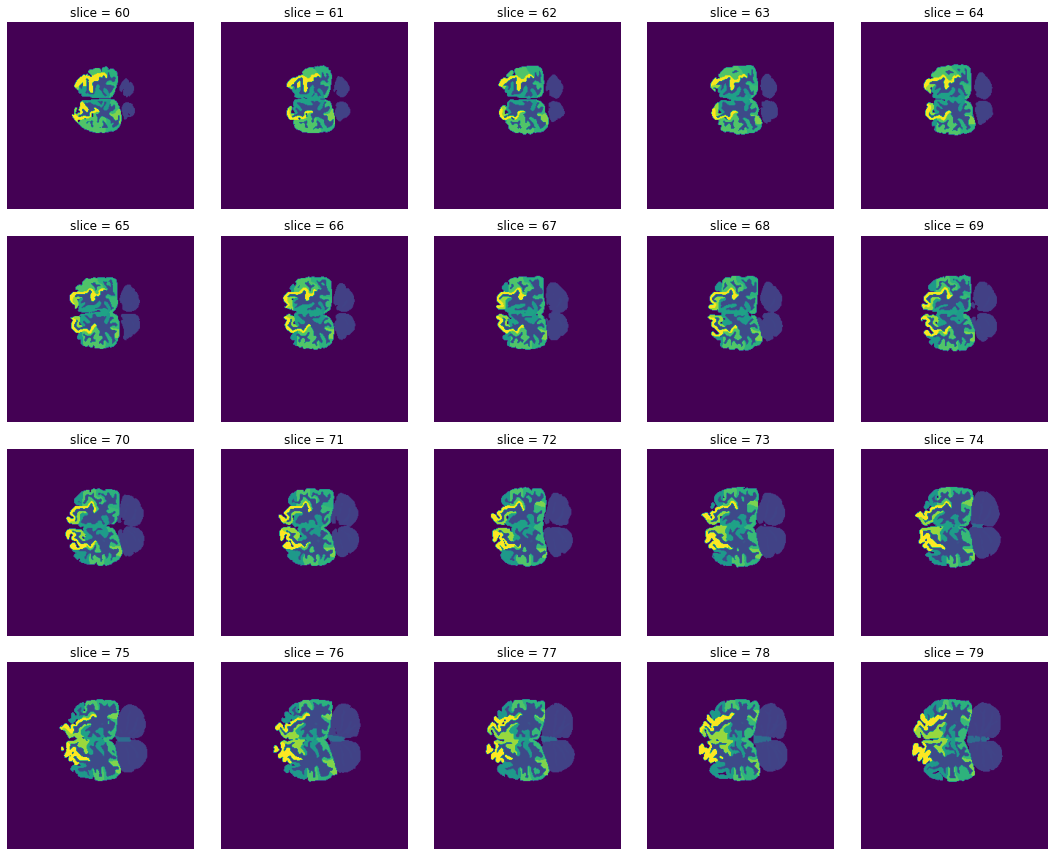

In [97]:
_ = display3d(data, start_slice=60, num_slices=20, figsize=(15,15), axis=2)

## DICOM

In [2]:
files = os.listdir("project")
data = dcmread(f"project/{files[1]}")
#data.dir() provides all the dict keys

In [3]:
def create3darr(dir_):
    """Returns array of shape (num_slices, h, w)"""
    files = os.listdir(dir_)
    data = [dcmread(f"{dir_}/{f}") for f in files] #all slices
    slice_loc = [float(d.SliceLocation) for d in data]
    indices_sort  = np.argsort(np.array(slice_loc))
    arr2d = np.array([d.pixel_array for d in data])
    arr3d = arr2d[indices_sort]
    return arr3d

In [30]:
a = 1
try:
    a= float(a)
except:
    pass
print(a)

1.0


In [39]:
def get_key_list():
    key_list = ['PatientSex', 'ScanningSequence', 'SequenceVariant',
                  'ScanOptions', 'SliceThickness', 'MagneticFieldStrength',
                  'SpacingBetweenSlices', 'ReconstructionDiameter', 
                  'AcquisitionMatrix', 'ImagesInAcquisition', 'SliceLocation', ]
    return key_list

class Patient():
    
    def __init__(self, patient_dir):
        self.patient_dir = patient_dir
        self.key_list = get_key_list()
    
    def reconstruct3d(self):
        """
        Combines the pixel data contained in dicom files of a patient to a 3d array.
        Returns: array of shape (num_slices, h, w)
        """
        files = os.listdir(self.patient_dir)
        dicom = [dcmread(f"{self.patient_dir}/{f}") for f in files]  # all slices
        slice_loc = [float(d.SliceLocation) for d in dicom]
        indices_sort = np.argsort(np.array(slice_loc))
        arr2d = np.array([d.pixel_array for d in dicom])
        arr3d = arr2d[indices_sort]
        return arr3d

    def patient_dictionary(self):
        files = os.listdir(self.patient_dir)
        dicom = dcmread(f"{self.patient_dir}/{files[0]}")
        patient_dict = {'volume':self.reconstruct3d()}
        for k in self.key_list: 
            value = getattr(dicom, k)
            try:
                value = float(value)
            except:
                pass
            
            try: 
                value = np.array(value)
            except:
                pass
            patient_dict[k] = value
        return patient_dict

In [41]:
p1 = Patient("project")
patient_dict = p1.patient_dictionary()

In [46]:
patient_dict.keys()

dict_keys(['volume', 'PatientSex', 'ScanningSequence', 'SequenceVariant', 'ScanOptions', 'SliceThickness', 'MagneticFieldStrength', 'SpacingBetweenSlices', 'ReconstructionDiameter', 'AcquisitionMatrix', 'ImagesInAcquisition', 'SliceLocation'])

In [50]:
patient_dict['AcquisitionMatrix'][1]

256

In [4]:
arr3d = create3darr("project")

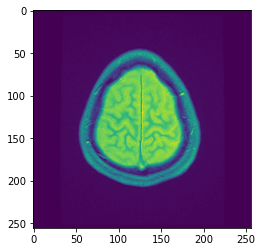

In [5]:
plt.imshow(arr3d[5,:,:])

In [11]:
relevant_parameter_list = ['PatientSex', 'ScanningSequence', 'SequenceVariant',
                          'ScanOptions', 'SliceThickness', 'MagneticFieldStrength',
                          'SpacingBetweenSlices', 'ReconstructionDiameter', 'AcquisitionMatrix',
                          'ImagesInAcquisition', 'SliceLocation', ]
lookup_parameters = ['In-plane Phase Encoding Direction', 'Flip Angle', 'Variable Flip Angle Flag',
                    'Patient Position', 'Rows', 'Columns', 'PixelSpacing', ]

In [29]:
float(data.SliceLocation)

0.1190530136

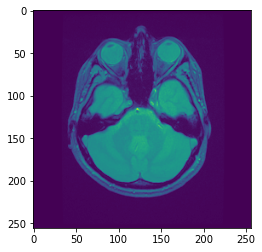

In [28]:
arr = data.pixel_array
plt.imshow(arr)

In [66]:
data.PatientSex

''